In [30]:
import pandas as pd
import numpy as np
import os
import datetime
import pickle as pkl
import sys
sys.path.append(r'/home/datamake8/hqth_sec_strategy')
sys.path.append(r'/home/datamake8/common_code')
from sec_support import *
from tonglian_config import *
import cvxpy as cp

ohlc_path = r'/home/datamake8/basic_data/tonglian_data2/ohlc_fea'
support_path = r'/home/datamake8/data0/trade_support'

TURNOVER_RATE = pd.read_feather(os.path.join(ohlc_path, 'TURNOVER_RATE.fea'))
TURNOVER_VALUE = pd.read_feather(os.path.join(ohlc_path, 'TURNOVER_VALUE.fea'))
MARKET_VALUE = pd.read_feather(os.path.join(ohlc_path, 'NEG_MARKET_VALUE.fea'))

TURNOVER_VALUE = TURNOVER_VALUE.set_index('TRADE_DATE')
TURNOVER_VALUE.index = pd.to_datetime(TURNOVER_VALUE.index).strftime('%Y%m%d')
TURNOVER_VALUE = TURNOVER_VALUE.rolling(5).mean().shift(1)
MARKET_VALUE = MARKET_VALUE.set_index('TRADE_DATE')
MARKET_VALUE.index = pd.to_datetime(MARKET_VALUE.index).strftime('%Y%m%d')
MARKET_VALUE = MARKET_VALUE.rolling(5).mean().shift(1)

class params:
    citic_share_limit = 0.002
    cmvg_share_limit = 0.002
    turnover_limit = 0.4
    hold_limit_ratio = 0.01
    t0_score_ratio = 0.1
    assume_rq_time = 5  # 假设每只股票最多能融5天
    idx_limit = pd.Series({'hs300':1,'zz500':1,'zz1000':1}).values

In [31]:
def get_target_stock_ratio(date):
    pre_date = date_list_all[date_list_all.index(date) - 1]

    # 读取trade_support信息
    td_support = pd.read_csv(os.path.join(support_path, f'{pre_date}_trade_support.csv'),index_col=0)
    valid_code = [x for x in td_support.index if x//10000 in [0,30,60,68]]
    td_support = td_support.loc[valid_code]
    stock_list = td_support.index.tolist()
    td_black = pd.read_csv(r'/home/datamake8/ITdev/sample_data/black_list/%s_black_list.csv'%pre_date,index_col=0)
    td_black = td_black[td_black['black']==True].index.tolist()
    td_black = [int(x) for x in td_black]
    stock_list = [x for x in stock_list if x not in td_black]

    zs1_cmvg=td_support.groupby('cmv_group')['hs300_member'].sum().sort_index()
    zs2_cmvg=td_support.groupby('cmv_group')['zz500_member'].sum().sort_index()
    zs3_cmvg=td_support.groupby('cmv_group')['zz1000_member'].sum().sort_index()
    zs_cmvg_mtx=pd.DataFrame({'hs300':zs1_cmvg,'zz500':zs2_cmvg,'zz1000':zs3_cmvg}).sort_index(axis=0).fillna(0)
    cmvg_mtx = pd.get_dummies(td_support.reindex(index=stock_list)['cmv_group']).T.astype(int).reindex(zs_cmvg_mtx.index).fillna(0).values
    zs_cmvg_mtx = zs_cmvg_mtx.values
    zs1_citic=td_support.groupby('citic1_code')['hs300_member'].sum().sort_index()
    zs2_citic=td_support.groupby('citic1_code')['zz500_member'].sum().sort_index()
    zs3_citic=td_support.groupby('citic1_code')['zz1000_member'].sum().sort_index()
    zs_citic_mtx=pd.DataFrame({'hs300':zs1_citic,'zz500':zs2_citic,'zz1000':zs3_citic}).sort_index(axis=0).fillna(0)
    citic_mtx = pd.get_dummies(td_support.reindex(index=stock_list)['citic1_code']).T.astype(int).reindex(zs_citic_mtx.index).fillna(0).values
    zs_citic_mtx = zs_citic_mtx.values

    #根据过去5日的股票打分情况筛选股票
    period_date_list = date_list_all[date_list_all.index(date)-5-1:date_list_all.index(date)-1]
    score_dict = {}
    for dt in period_date_list:
        if dt <= '20230630': score_path = r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0323_wccc_all'
        # else: score_path = r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0323_wccc_all_sota2'
        else: score_path = r'/home/datamake8/datamake94/second_score/dcn_bert_multiperiod_5m_final_0529_factor1057_wccc_all_sota2_final'
        score_data = pd.read_feather(os.path.join(score_path, f'{dt}.fea')).set_index('second')
        # score_data = get_alpha_dict(stock_list,dt,score_ratio_1m=0.2,score_ratio_15s=0.2, score_ratio_5m=0.6)['sec_300s']
        score_data.columns = score_data.columns.astype(int)
        score_std = score_data.std(axis=0)
        score_range = score_data.max(axis=0) - score_data.min(axis=0)
        score_dict[dt] = score_std.rank(pct=True) + score_range.rank(pct=True)
    score_mean = pd.DataFrame(score_dict).mean(axis=1).reindex(stock_list).fillna(0)
    score_select_stock_long = score_mean[score_mean.rank(pct=True)>(1-params.t0_score_ratio)].index.tolist()
    score_select_stock_short = score_mean[score_mean.rank(pct=True)>(1-params.t0_score_ratio)].index.tolist()

    #根据过去1日的长周期股票打分情况筛选股票
    period_date_list = date_list_all[date_list_all.index(date)-1-1:date_list_all.index(date)-1]
    score_dict_short = {}
    model_ratio = {'norm':1}
    score_path_dict = {
        'norm':r'/home/datamake8/database_00/min_score_period30/min_score_period1d_allstock_adj_transformer_final_select3_doublenorm_ver2_0618_wpcc_pwtrain',
        'tabnet':r'/home/datamake8/database_00/min_score_period30/min_score_period1d_allstock_adj_tabnet_final_select3_doublenorm_ver2_0618_wpcc_pwtrain',
    }
    for dt in period_date_list:
        score_model_list = []
        for model_tag in list(model_ratio.keys()):
            score_data = pd.read_feather(os.path.join(score_path_dict[model_tag], f'{dt}.fea')).set_index('index').loc[1440:]
            # score_data = get_alpha_dict(stock_list,dt,score_ratio_1m=0.2,score_ratio_15s=0.2, score_ratio_5m=0.6)['sec_300s']
            score_data.columns = score_data.columns.astype(int)
            # score_model_list.append(score_data.mean(axis=0).rank(pct=True).reindex(stock_list).fillna(0.5) * model_ratio[model_tag])
            score_data = score_data.mean(axis=0)#.rank(pct=True)
            score_model_list.append(score_data * model_ratio[model_tag])

        score_dict_short[dt] = sum(score_model_list)
    score_mean_short = pd.DataFrame(score_dict_short).mean(axis=1).reindex(stock_list).fillna(0)

    #将score_mean按大小划为6组，对股票进行分组
    score_mean_group = score_mean.rank(pct=True).apply(lambda x:0 if x<0.1 else 1 if x<0.3 else 2 if x<0.5 else 3 if x<0.7 else 4 if x<0.9 else 5 if ~np.isnan(x) else np.nan)
    score_mean_group = pd.get_dummies(score_mean_group).reindex(index=stock_list).astype(int).fillna(0).T.values
    zs1_score_group = score_mean_group @ td_support['hs300_member'].reindex(index=stock_list)
    zs2_score_group = score_mean_group @ td_support['zz500_member'].reindex(index=stock_list)
    zs3_score_group = score_mean_group @ td_support['zz1000_member'].reindex(index=stock_list)
    zs_score_group_mtx = pd.DataFrame({'hs300':zs1_score_group,'zz500':zs2_score_group,'zz1000':zs3_score_group}).sort_index(axis=0).fillna(0).values

    # 开始组合优化，多空+T0双打分优化

    def make_parameter(param_s,fill=0):
        return param_s.reindex(stock_list).replace([np.inf,-np.inf],np.nan).fillna(fill).values #cp.Parameter(

    n = len(stock_list)
    for i in range(30):
        cons = []
        zeros = np.repeat(0, n).T
        ones = np.repeat(1, n).T
        allhold_amt = cp.Variable(n, nonneg=True, integer=False)
        idx_ratio = cp.Variable(3, nonneg=True, integer=False)  #指数占比
        citic_share_limit, cmvg_share_limit = (i+1)*params.citic_share_limit, (i+1)*params.cmvg_share_limit

        # 市值约束
        all_cmvg = cmvg_mtx @ allhold_amt
        zs_cmvg = zs_cmvg_mtx @ idx_ratio
        hold_perm = td_support[['hs300_member','zz500_member','zz1000_member']].reindex(index=stock_list).fillna(0).values @ idx_ratio
        mv_value = MARKET_VALUE.loc[date_list[date_list.index(date)-2]]
        mv_value.index = [int(x) for x in mv_value.index]
        mv_value[mv_value<0] = 0
        mv_value = mv_value.reindex(index=stock_list).replace([0,np.inf,-np.inf],np.nan)
        mv_value = np.log(mv_value.fillna(mv_value.mean()))
        mv_value_mean = mv_value.values @ hold_perm
        mv_value_std = mv_value.std()
        cons.extend([all_cmvg + cmvg_share_limit >= zs_cmvg,
                        all_cmvg - cmvg_share_limit <= zs_cmvg,
                        mv_value.values @ allhold_amt >= mv_value_mean - 0.15*mv_value_std,
                        mv_value.values @ allhold_amt <= mv_value_mean + 0.15*mv_value_std,
                        ])
        #行业约束
        all_citic = citic_mtx @ allhold_amt
        zs_citic = zs_citic_mtx @ idx_ratio
        cons.extend([all_citic + citic_share_limit >= zs_citic,
                        all_citic - citic_share_limit <= zs_citic,
                        ])

        #个股持仓约束
        zs_keep = td_support[['hs300_member','zz500_member','zz1000_member']].reindex(index=stock_list).fillna(0).sum(axis=1)
        hold_limit_up = pd.Series({stock: params.hold_limit_ratio if stock in score_select_stock_long and stock not in td_black else 0 for stock in stock_list}).values
        hold_limit_down = pd.Series({stock: 1 if zs_keep[stock]==0 or stock not in score_select_stock_long else params.hold_limit_ratio for stock in stock_list}).values
        cons.extend([
            allhold_amt >= hold_perm - hold_limit_down,
            allhold_amt <= hold_perm + hold_limit_up,
            allhold_amt >= 0,
        ])
        # zs_keep = td_support[['hs300_member','zz500_member','zz1000_member']].reindex(index=stock_list).fillna(0).sum(axis=1)
        # hold_limit_up = pd.Series({stock: params.hold_limit_ratio if stock in score_select_stock_long and stock not in td_black else 0 for stock in stock_list}).values
        # hold_limit_down = pd.Series({stock: 0 for stock in stock_list}).values
        # cons.extend([
        #     allhold_amt >= hold_limit_down,
        #     allhold_amt <= hold_limit_up,
        #     allhold_amt >= 0,
        # ])

        #其他约束
        cons.extend([
            cp.sum(allhold_amt) <= 1,
            cp.sum(allhold_amt) >= 0.995,
            cp.sum(idx_ratio) >= 0.995,
            cp.sum(idx_ratio) <= 1,
        ])

        # 定义问题，仓位打分差最小化
        obj = cp.Maximize(score_mean_short.values @ allhold_amt)

        prob = cp.Problem(obj, cons)
        # 求解
        ans = prob.solve(solver='SCIPY',verbose=False)
        if allhold_amt.value is not None:
            break

        # if (allhold_amt.value is None) and i==29:
        #     print(date, '组合优化始终无解')
        #     return date, {}

    output = pd.Series(allhold_amt.value,index=stock_list)
    idx_ratio = pd.Series(idx_ratio.value,index=['hs300','zz500','zz1000'])
    output = output[output!=0].copy()
    idx_output = idx_ratio.copy()
    return date, output.to_dict(), idx_output.to_dict()

In [32]:
valid_stock_dict = {}
valid_idx_ratio = {}
date_list_all = get_datelist_all()
date_list = get_datelist('20230103','20240430')
# dl = DataLoaderX(SDataset(date_list[6:],get_target_stock_ratio),collate_fn=lambda x:x[0],batch_size=1,num_workers=0,shuffle=False,drop_last=False)
path = r'/home/datamake8/data0/底仓T0股票/期货_stk_dict_update20240702_2'
os.makedirs(path,exist_ok=True)
params_dict = {
    'citic_share_limit':params.citic_share_limit,
    'cmvg_share_limit':params.cmvg_share_limit,
    'turnover_limit':params.turnover_limit,
    'hold_limit_ratio_long':params.hold_limit_ratio,
    't0_score_ratio':params.t0_score_ratio,
}
with open(os.path.join(path, 'params.pkl'),'wb') as f:
    pkl.dump(params_dict,f)
dl = DataLoaderX(SDataset(date_list[6:],get_target_stock_ratio),collate_fn=lambda x:x[0],batch_size=1,num_workers=10,shuffle=False,drop_last=False)
for batch in tqdm(dl, total=len(dl)):
    date,valid_stock_list,idx_ratio = batch
    valid_stock_dict[date] = valid_stock_list
    valid_idx_ratio[date] = idx_ratio
    with open(os.path.join(path, date+'.pkl'),'wb') as f:
        pkl.dump((valid_stock_list,idx_ratio),f)

  0%|                                                                         | 0/314 [00:00<?, ?it/s]

  4%|██▏                                                             | 11/314 [00:09<04:14,  1.19it/s]


SolverError: Caught SolverError in DataLoader worker process 1.
Original Traceback (most recent call last):
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/datamake8/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/datamake8/hqth_sec_strategy/sec_support.py", line 61, in __getitem__
    result=self.function(date)
  File "/tmp/ipykernel_52298/2867476047.py", line 141, in get_target_stock_ratio
    ans = prob.solve(solver='SCIPY',verbose=False)
  File "/home/datamake8/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py", line 503, in solve
    return solve_func(self, *args, **kwargs)
  File "/home/datamake8/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py", line 1086, in _solve
    self.unpack_results(solution, solving_chain, inverse_data)
  File "/home/datamake8/.local/lib/python3.8/site-packages/cvxpy/problems/problem.py", line 1411, in unpack_results
    raise error.SolverError(
cvxpy.error.SolverError: Solver 'SCIPY' failed. Try another solver, or solve with verbose=True for more information.


100%|████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 232.25it/s]


<Axes: >

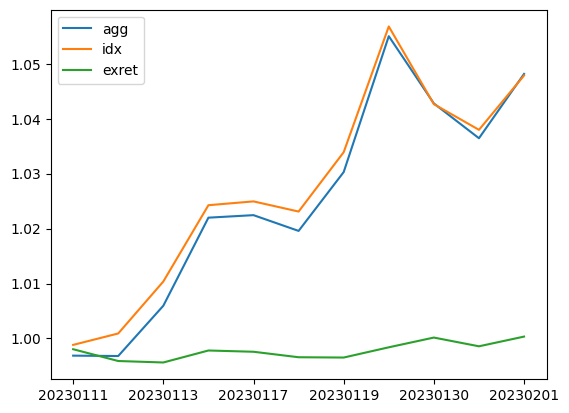

In [33]:
OPEN = pd.read_feather(os.path.join(ohlc_path, 'OPEN_PRICE_2.fea')).set_index('TRADE_DATE')
OPEN.index = pd.to_datetime(OPEN.index).strftime('%Y%m%d')
OPEN = OPEN.pct_change().shift(-1).replace([np.inf, -np.inf], np.nan)
idx_open = pd.read_feather(r'/home/datamake8/data0/support_data/index_d_open_ts.fea').set_index('index')
idx_open.index = pd.to_datetime(idx_open.index).strftime('%Y%m%d')
idx_open = idx_open[['沪深300','中证500','中证1000']].rename(columns={'沪深300':'hs300','中证500':'zz500','中证1000':'zz1000'})
idx_open = idx_open.pct_change().shift(-1)

#计算组合框架的收益和指数收益
agg_se = pd.Series(index=date_list[6:])
idx_se = pd.Series(index=date_list[6:])
for date in tqdm(valid_idx_ratio.keys()):
    target_stock = pd.Series(valid_stock_dict[date])
    target_stock.index = ['%06d'%x for x in target_stock.index]
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = idx_open.loc[date].mul(pd.Series(valid_idx_ratio[date]).values).sum()
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()

100%|██████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 375.15it/s]


agg      0.953165
idx      0.477426
exret    2.007349
Name: 20240430, dtype: float64 agg     -0.515503
idx     -0.919778
exret   -0.053310
dtype: float64


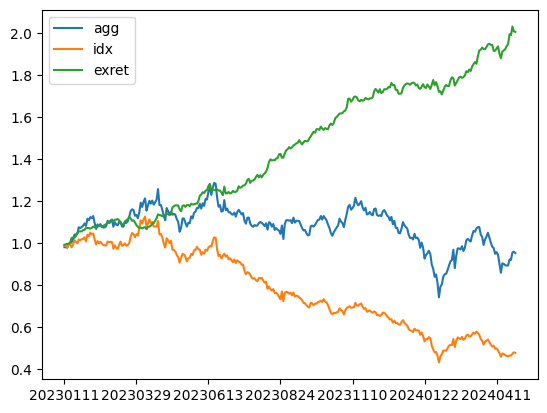

In [147]:
OPEN = pd.read_feather(os.path.join(ohlc_path, 'OPEN_PRICE_2.fea')).set_index('TRADE_DATE')
OPEN.index = pd.to_datetime(OPEN.index).strftime('%Y%m%d')
OPEN = OPEN.pct_change().shift(-1).replace([np.inf, -np.inf], np.nan)
idx_open = pd.read_feather(r'/home/datamake8/data0/support_data/index_d_open_ts.fea').set_index('index')
idx_open.index = pd.to_datetime(idx_open.index).strftime('%Y%m%d')
idx_open = idx_open[['沪深300','中证500','中证1000']].rename(columns={'沪深300':'hs300','中证500':'zz500','中证1000':'zz1000'})
idx_open = idx_open.pct_change().shift(-1)
###
idx_open = idx_open['hs300'] * 0.2

#计算组合框架的收益和指数收益
dt_list = get_datelist('20230111','20240430')[:]
agg_se = pd.Series(index=dt_list)
idx_se = pd.Series(index=dt_list)
for date in tqdm(dt_list):
    with open(os.path.join(r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240702_0',date+'.pkl'),'rb') as f:
        all_stock = pd.Series(pkl.load(f))
    all_stock.index = ['%06d'%x for x in all_stock.index]
    target_stock = all_stock[all_stock>0].copy()
    rq_stock = -all_stock[all_stock<0].copy() * 0.8
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = OPEN.loc[date].reindex(rq_stock.index).fillna(0).mul(rq_stock).sum() + idx_open.loc[date]
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()
print((total_df+1).cumprod().iloc[-1], ((total_df.cumsum()+1)-(total_df.cumsum()+1).cummax()).min())

100%|██████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 402.68it/s]


agg      0.953165
idx      0.401682
exret    2.329421
Name: 20240430, dtype: float64 agg     -0.515503
idx     -1.087406
exret   -0.066727
dtype: float64


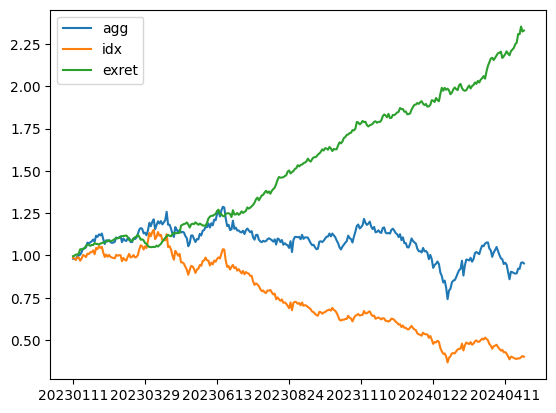

In [142]:
for date in tqdm(dt_list):
    with open(os.path.join(r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240702_0',date+'.pkl'),'rb') as f:
        all_stock = pd.Series(pkl.load(f))
    all_stock.index = ['%06d'%x for x in all_stock.index]
    target_stock = all_stock[all_stock>0].copy()
    rq_stock = -all_stock[all_stock<0].copy()
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = OPEN.loc[date].reindex(rq_stock.index).fillna(0).mul(rq_stock).sum()
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()
print((total_df+1).cumprod().iloc[-1], ((total_df.cumsum()+1)-(total_df.cumsum()+1).cummax()).min())

In [91]:
rq_stock.sum()

0.4049999999999997

In [8]:
#检验融券是否有问题
path = r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240626_1'

for date in tqdm(date_list[7:]):
    pre_date = date_list_all[date_list_all.index(date) - 1]
    with open(os.path.join(path, date+'.pkl'),'rb') as f:
        holdamt = pd.Series(pkl.load(f))
    with open(os.path.join(path, pre_date+'.pkl'),'rb') as f:
        preamt = pd.Series(pkl.load(f))
    stock_list = list(set(holdamt.index) | set(preamt.index))
    holdamt = holdamt.reindex(stock_list).fillna(0)
    preamt = preamt.reindex(stock_list).fillna(0)
    total_rq = holdamt * (holdamt<0).astype(int)
    pre_rq = preamt * (preamt<0).astype(int)

    #筛选融券名单
    period_date_list = date_list_all[date_list_all.index(date)-params.assume_rq_time:date_list_all.index(date)]
    total_rq_stock = []
    for dt in period_date_list:
        daily_rq_stock_df = pd.read_pickle(r'/home/datamake8/data0/海通券单_新/%s.pkl'%dt)
        daily_rq_stock_df = daily_rq_stock_df[~pd.isnull(daily_rq_stock_df['code'])].copy()
        daily_rq_stock_df['code'] = daily_rq_stock_df['code'].astype(int)
        daily_rq_stock = sorted(daily_rq_stock_df['code'].drop_duplicates().tolist())
        daily_rq_stock = [x for x in daily_rq_stock if x in stock_list]
        total_rq_stock.extend(daily_rq_stock)
    total_rq_stock = sorted(list(set(total_rq_stock)))
    if len([x for x in stock_list if total_rq[x] < 0 and x not in total_rq_stock]):
        print(date, 'warning1')
    if len([x for x in stock_list if total_rq[x] - pre_rq[x] < 0 and abs(total_rq[x] - pre_rq[x]) > 1e-5 and x not in daily_rq_stock]):
        print(date, 'warning2')

100%|███████████████████████████████████████████████████████████████| 272/272 [00:10<00:00, 25.86it/s]


100%|██████████████████████████████████████████████████████████████| 275/275 [00:00<00:00, 333.45it/s]


<Axes: >

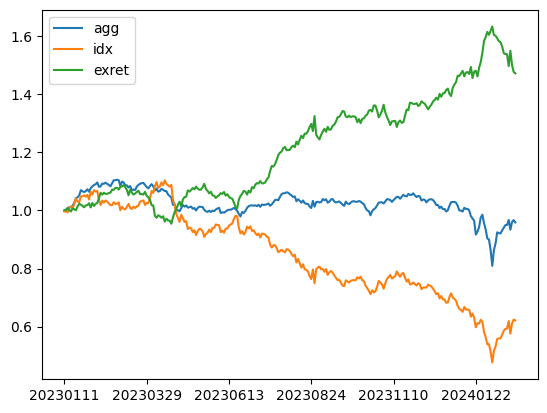

In [57]:
OPEN = pd.read_feather(os.path.join(ohlc_path, 'OPEN_PRICE_2.fea')).set_index('TRADE_DATE')
OPEN.index = pd.to_datetime(OPEN.index).strftime('%Y%m%d')
OPEN = OPEN.pct_change().shift(-1).replace([np.inf, -np.inf], np.nan)

#计算组合框架的收益和指数收益
dt_list = list(valid_stock_dict.keys())
agg_se = pd.Series(index=dt_list)
idx_se = pd.Series(index=dt_list)
for date in tqdm(dt_list):
    # with open(os.path.join(r'/home/datamake8/data0/底仓T0股票/stk_dict_update20240622',date+'.pkl'),'rb') as f:
    #     all_stock = pd.Series(pkl.load(f))
    all_stock = pd.Series(valid_stock_dict[date])
    all_stock.index = ['%06d'%x for x in all_stock.index]
    target_stock = all_stock[all_stock>0].copy()
    rq_stock = -all_stock[all_stock<0].copy()
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = OPEN.loc[date].reindex(rq_stock.index).fillna(0).mul(rq_stock).sum()
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()

In [ ]:
with open(r'/home/datamake8/data0/底仓T0股票/test20240619_allstk_long_0.01_update20240620.pkl','wb') as f:
    pkl.dump(valid_stock_dict,f)

100%|██████████████████████████████████████████████████████████████| 236/236 [00:00<00:00, 568.75it/s]


<Axes: >

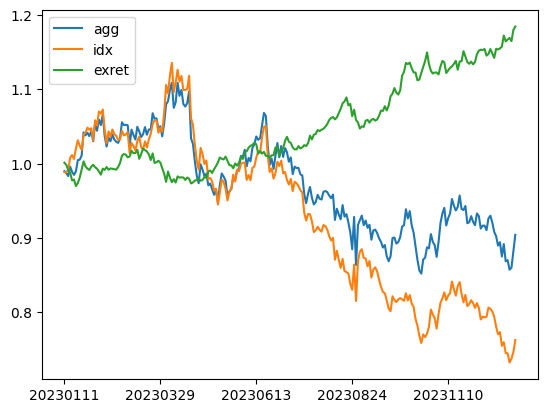

In [ ]:
OPEN = pd.read_feather(os.path.join(ohlc_path, 'OPEN_PRICE_2.fea')).set_index('TRADE_DATE')
OPEN.index = pd.to_datetime(OPEN.index).strftime('%Y%m%d')
OPEN = OPEN.pct_change().shift(-1).replace([np.inf, -np.inf], np.nan)

#计算组合框架的收益和指数收益
dt_list = list(valid_stock_dict.keys())
agg_se = pd.Series(index=dt_list)
idx_se = pd.Series(index=dt_list)
for date in tqdm(dt_list):
    if dt_list.index(date)%5==0:
        all_stock = pd.Series(valid_stock_dict[date])
        all_stock.index = ['%06d'%x for x in all_stock.index]
        target_stock = all_stock[all_stock>0].copy()
        rq_stock = -all_stock[all_stock<0].copy()
    agg_ret = OPEN.loc[date].reindex(target_stock.index).fillna(0).mul(target_stock).sum()
    idx_ret = OPEN.loc[date].reindex(rq_stock.index).fillna(0).mul(rq_stock).sum()
    agg_se[date] = agg_ret
    idx_se[date] = idx_ret
total_df = pd.DataFrame({'agg':agg_se,'idx':idx_se})
total_df['exret'] = total_df['agg'] - total_df['idx']
(total_df+1).cumprod().plot()

In [ ]:
valid_stock_dict['20230112']

{6: 0.0015,
 25: 0.0015,
 32: 0.0015,
 34: 0.0015,
 35: 0.0015,
 40: 0.0015,
 49: 0.0015,
 58: 0.0015,
 60: 0.0015,
 400: 0.0015,
 403: 0.0015,
 537: 0.0015,
 560: 0.0015,
 561: 0.0015,
 563: 0.0015,
 567: 0.0015,
 576: 0.0015,
 591: 0.0015,
 593: 0.0004348802009875776,
 597: 0.0015,
 603: 0.0015,
 610: 0.0009374258332409216,
 615: 0.0015,
 629: 0.0015,
 630: 0.0015,
 657: 0.0015,
 666: 0.0015,
 681: 0.0015,
 683: 0.0015,
 690: 0.0015,
 698: 0.0015,
 721: 0.0015,
 729: 0.0015,
 736: 0.00023330874760570108,
 737: 0.0015,
 739: 0.0015,
 762: 0.0015,
 807: 0.0015,
 815: 0.0015,
 818: 0.0015,
 848: 0.0015,
 860: 0.0015,
 887: 0.0015,
 909: 0.0015,
 913: 0.0015,
 915: 0.0015,
 921: 0.0015,
 923: 0.0015,
 935: 0.0015,
 951: 0.0015,
 961: 0.0015,
 970: 0.0015,
 975: 0.0015,
 998: 0.0015,
 999: 0.0015,
 1217: 0.0015,
 1258: 0.0015,
 1270: 0.0015,
 1301: 0.0015,
 1338: 0.0015,
 1914: 0.0015,
 2002: 0.0015,
 2006: 0.0015,
 2010: 0.0015,
 2011: 0.0015,
 2015: 0.0015,
 2020: 0.0015,
 2025: 0.0015,